# 🧠 fMRI Decoding with the Haxby Dataset

This notebook performs multivariate pattern analysis (MVPA) on the Haxby 2001 fMRI dataset to classify visual stimuli based on brain activation patterns. The analysis includes:

* Binary Classification: Faces vs. Houses classification using SVM
* Searchlight Analysis: Spatially localized decoding across the brain
* Multi-class Classification: Classification of all visual categories
* Representational Similarity Analysis (RSA): Exploring neural representation structure

### Key Features:
* fMRI data preprocessing and masking
* Cross-validation with proper train/test splitting
* Spatial searchlight decoding
* Feature selection and hyperparameter tuning
* Permutation testing for statistical validation

In [19]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Neuroimaging libraries
from nilearn import datasets, image, masking, plotting
from nilearn.maskers import NiftiMasker
from nilearn.decoding import SearchLight
from nilearn.image import index_img

# Machine learning libraries
from sklearn.model_selection import (cross_val_score, cross_val_predict,
                                   StratifiedKFold, GridSearchCV, LeaveOneGroupOut)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

# Statistical and utility libraries
from scipy.spatial.distance import pdist, squareform
from scipy.stats import zscore, ttest_1samp
from scipy.ndimage import distance_transform_edt

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('bmh')
sns.set_palette("husl")

### Data Loading and Preprocessing

Loading the Haxby 2001 dataset, which includes:
- **fMRI scans** collected while a participant viewed various object categories
- **Labels** indicating which stimulus was shown at each time point
- **Masks** for both the whole brain and a region of interest (ventral temporal cortex)

We then preprocess the fMRI data with the following steps:
- **Masking**: Extract only the voxels within a specified brain region.
- **Z-scoring**: Standardize voxel time courses within each run to have mean 0 and unit variance, which removes baseline shifts and ensures comparability across runs.
- **HRF shift**: Apply a temporal shift to account for the hemodynamic response delay (~4–6 seconds after stimulus onset). We shift conditions backward by 2 TRs (time repetitions).
- **Rest removal**: Remove "rest" periods from the dataset so that the model trains only on meaningful stimulus events.

In [20]:
def load_haxby_data():
    """Load Haxby dataset and extract relevant files."""
    print("Loading Haxby dataset...")

    # Fetch dataset
    haxby_dataset = datasets.fetch_haxby(data_dir='haxby_data', subjects=[2], fetch_stimuli=True)

    # Extract file paths
    func_filename = haxby_dataset.func[0]
    labels_filename = haxby_dataset.session_target[0]
    mask_vt_filename = haxby_dataset.mask_vt[0]  # Ventral Temporal mask
    mask_whole_brain = haxby_dataset.mask  # Whole-brain mask

    # Load behavioral data
    behavioral = pd.read_csv(labels_filename, sep=" ")

    # Load fMRI data
    fmri_img = image.load_img(func_filename)
    mean_img = image.mean_img(fmri_img)

    print(f"Dataset loaded successfully:")
    print(f"- fMRI shape: {fmri_img.shape}")
    print(f"- Behavioral data shape: {behavioral.shape}")
    print(f"- Unique conditions: {behavioral['labels'].unique()}")

    return {
        'fmri_img': fmri_img,
        'mean_img': mean_img,
        'behavioral': behavioral,
        'masks': {
            'ventral_temporal': mask_vt_filename,
            'whole_brain': mask_whole_brain
        },
        'dataset': haxby_dataset
    }

In [21]:
def preprocess_fmri_data(data_dict):
    """Preprocess fMRI data with masking, z-scoring, and HRF correction."""
    print("Preprocessing fMRI data...")

    fmri_img = data_dict['fmri_img']
    behavioral = data_dict['behavioral']
    masks = data_dict['masks']

    # Extract original labels and runs
    stimuli_original = behavioral['labels'].values
    runs_original = behavioral['chunks'].values

    # Apply whole-brain mask
    masker_whole_brain = NiftiMasker(mask_img=masks['whole_brain'], standardize=False)
    fmri_masked = masker_whole_brain.fit_transform(fmri_img)

    # Z-score within each run
    fmri_zscored = np.zeros_like(fmri_masked)
    for run in np.unique(runs_original):
        run_indices = np.where(runs_original == run)[0]
        fmri_zscored[run_indices] = zscore(fmri_masked[run_indices], axis=0)

    # Apply VT mask to z-scored data
    masker_vt = NiftiMasker(mask_img=masks['ventral_temporal'], standardize=False)
    fmri_vt = masker_vt.fit_transform(masker_whole_brain.inverse_transform(fmri_zscored))

    # Apply HRF shift (2 TRs)
    HRF_SHIFT = 2
    shifted_conditions = np.roll(stimuli_original, -HRF_SHIFT)[:-HRF_SHIFT]
    shifted_runs = np.roll(runs_original, -HRF_SHIFT)[:-HRF_SHIFT]
    fmri_shifted = fmri_vt[:-HRF_SHIFT, :]

    # Remove rest periods
    non_rest_mask = shifted_conditions != "rest"
    final_conditions = shifted_conditions[non_rest_mask]
    final_runs = shifted_runs[non_rest_mask]
    final_fmri = fmri_shifted[non_rest_mask, :]

    print(f"Preprocessing complete:")
    print(f"- Final fMRI shape: {final_fmri.shape}")
    print(f"- Non-rest conditions: {len(final_conditions)}")
    print(f"- Unique conditions: {np.unique(final_conditions)}")

    return {
        'fmri_data': final_fmri,
        'conditions': final_conditions,
        'runs': final_runs,
        'maskers': {
            'whole_brain': masker_whole_brain,
            'ventral_temporal': masker_vt
        }
    }

# Load and preprocess data
data_dict = load_haxby_data()
processed_data = preprocess_fmri_data(data_dict)

Loading Haxby dataset...
[fetch_haxby] Dataset found in haxby_data/haxby2001
Dataset loaded successfully:
- fMRI shape: (40, 64, 64, 1452)
- Behavioral data shape: (1452, 2)
- Unique conditions: ['rest' 'scissors' 'face' 'cat' 'shoe' 'house' 'scrambledpix' 'bottle'
 'chair']
Preprocessing fMRI data...
Preprocessing complete:
- Final fMRI shape: (864, 464)
- Non-rest conditions: 864
- Unique conditions: ['bottle' 'cat' 'chair' 'face' 'house' 'scissors' 'scrambledpix' 'shoe']


### Visualizing the Brain and ROI Masks

Visualize the brain and the anatomical masks used:
- **Mean EPI Image**: The average functional image across time.
- **Whole-brain mask**: Includes all brain voxels.
- **Ventral temporal (VT) mask**: A region known for visual object processing, including faces (fusiform face area, FFA) and scenes (parahippocampal place area, PPA).

### Stimulus Presentation Timeline

This timeline shows which category of stimulus (face, house, etc.) was presented at each time point (TR). It also marks the boundaries between scanning runs. Each vertical bar represents a stimulus presentation, and each row represents a different stimulus category.

In [22]:
def visualize_data(data_dict, processed_data):
    """Create comprehensive visualizations of the data."""

    # Brain anatomy and masks
    fig, axes = plt.subplots(3, 1, figsize=(12, 16))

    # Mean EPI
    plotting.plot_epi(data_dict['mean_img'],
                     title="Mean EPI Image",
                     axes=axes[0],
                     cut_coords=[-25, -35, -5],
                     colorbar=False)

    # Whole brain mask visualization
    masker_wb = processed_data['maskers']['whole_brain']
    masked_wb = masking.apply_mask(data_dict['fmri_img'], data_dict['masks']['whole_brain'])
    unmasked_wb = masking.unmask(masked_wb, data_dict['masks']['whole_brain'])

    plotting.plot_roi(image.mean_img(unmasked_wb),
                     bg_img=data_dict['mean_img'],
                     title="Whole Brain Mask",
                     axes=axes[1],
                     cut_coords=[-25, -35, -5],
                     colorbar=False)

    # VT mask visualization
    masker_vt = processed_data['maskers']['ventral_temporal']
    masked_vt = masking.apply_mask(data_dict['fmri_img'], data_dict['masks']['ventral_temporal'])
    unmasked_vt = masking.unmask(masked_vt, data_dict['masks']['ventral_temporal'])

    plotting.plot_roi(image.mean_img(unmasked_vt),
                     bg_img=data_dict['mean_img'],
                     title="Ventral Temporal Mask",
                     axes=axes[2],
                     cut_coords=[-25, -35, -5],
                     colorbar=False)

    plt.tight_layout()
    plt.show()

    # Stimulus timing
    behavioral = data_dict['behavioral']
    fig, ax = plt.subplots(figsize=(16, 6))

    # Plot stimulus presentations
    for i, condition in enumerate(behavioral["labels"].unique()):
        condition_times = behavioral[behavioral["labels"] == condition].index
        ax.plot(condition_times, [i] * len(condition_times), "|",
               label=condition, markersize=8, markeredgewidth=2)

    # Mark run boundaries
    run_starts = behavioral[behavioral["chunks"].diff() != 0].index
    for i, run_start in enumerate(run_starts):
        ax.axvline(x=run_start, color="black", alpha=0.6, linestyle="--", linewidth=1)
        ax.text(run_start, -0.5, f"Run {i+1}", rotation=90,
               verticalalignment="bottom", fontsize=10)

    ax.set_title("Stimulus Presentation Timeline", fontsize=16, pad=20)
    ax.set_xlabel("Time (TRs)", fontsize=14)
    ax.set_ylabel("Stimulus Category", fontsize=14)
    ax.set_yticks(range(len(behavioral["labels"].unique())))
    ax.set_yticklabels(behavioral["labels"].unique())
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

### Z-Scoring and HRF Shift: Signal Processing Check

**Z-scoring** is applied to each voxel's time series *within each run*, so that each run has zero mean and unit variance. This step removes between-run variability and improves model generalization.

**HRF shift** accounts for the slow nature of the BOLD signal. Since neural activity causes a delayed change in the BOLD response, we shift the stimulus labels backward by 2 TRs (~4 seconds) so they align with the peak BOLD signal.

This cell plots the raw and z-scored signal for a sample voxel, illustrating how standardization changes the data.

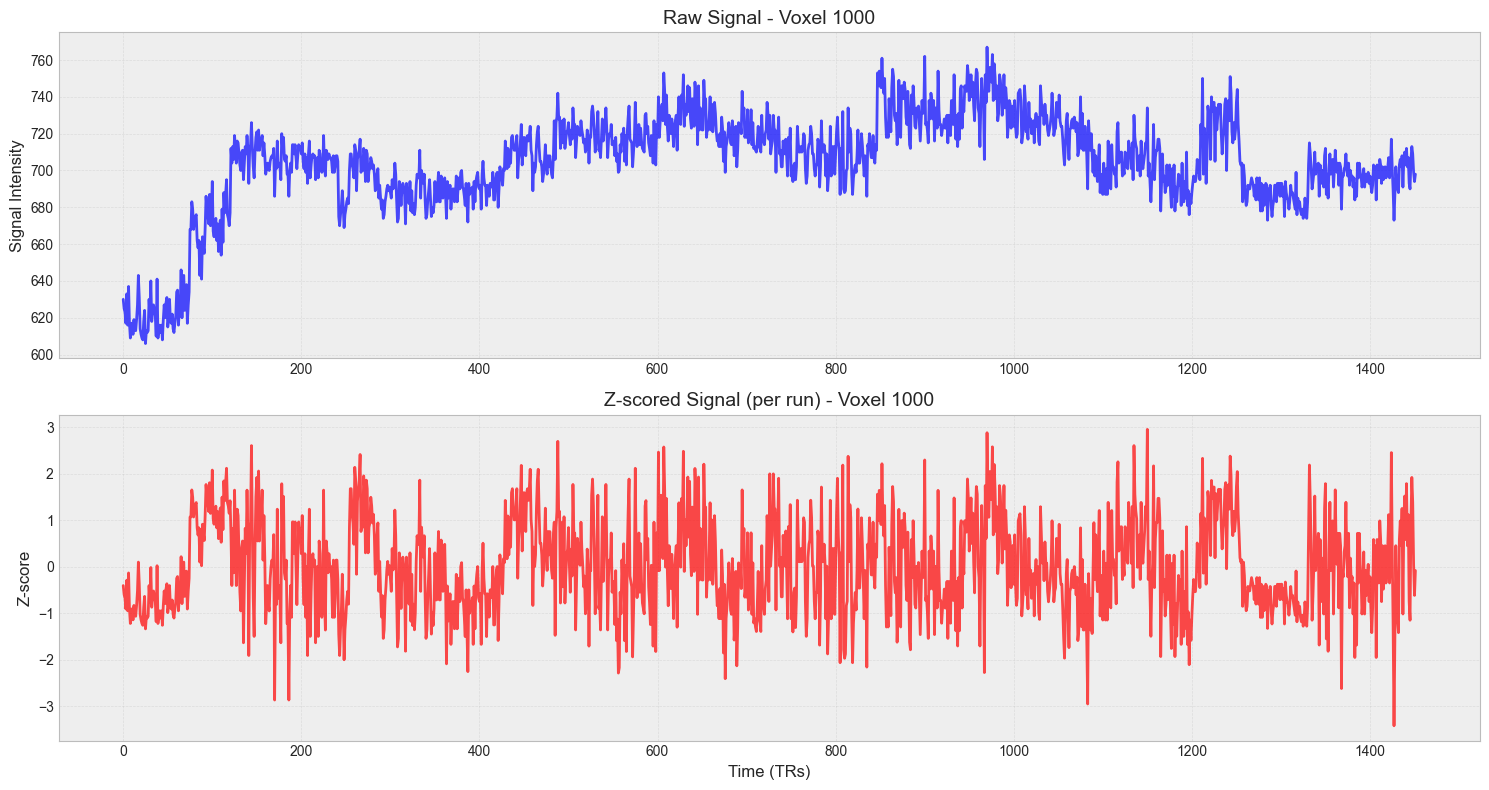

Creating data visualizations...


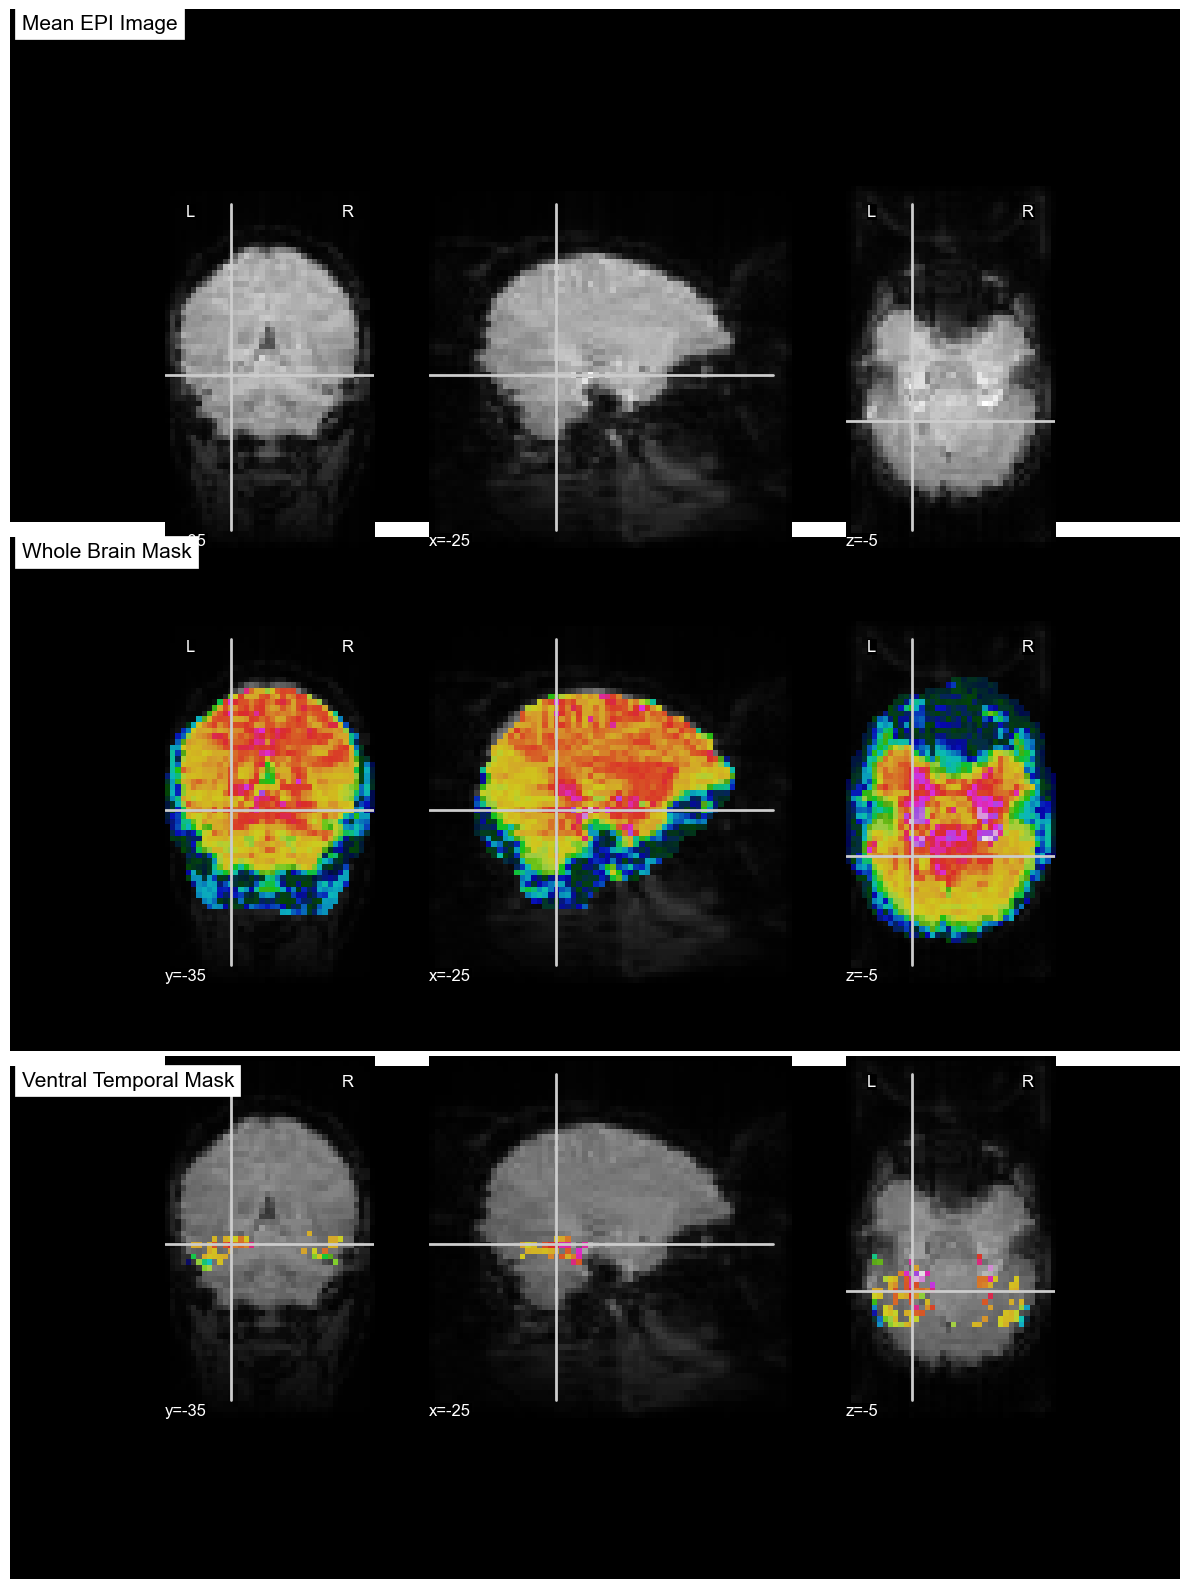

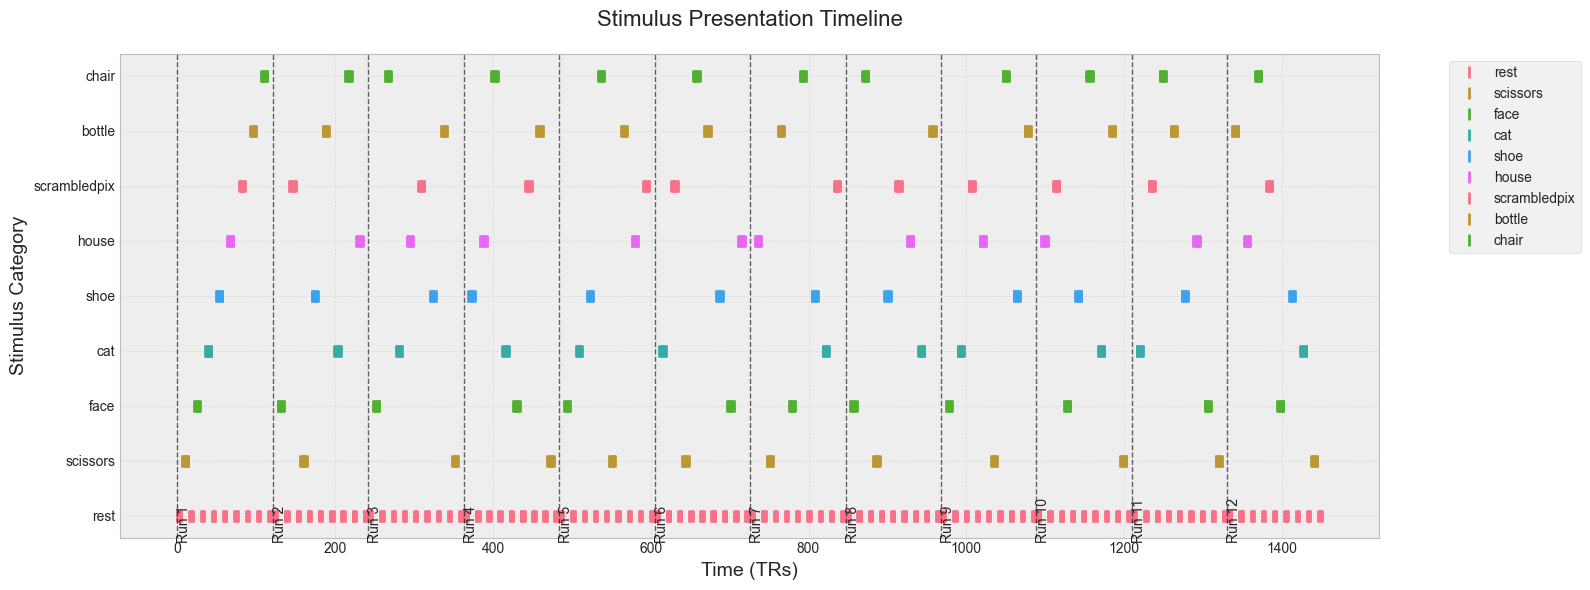

In [23]:
# Show effect of z-scoring on a sample voxel
if 'fmri_img' in data_dict:
    masker_demo = NiftiMasker(mask_img=data_dict['masks']['whole_brain'], standardize=False)
    raw_data = masker_demo.fit_transform(data_dict['fmri_img'])

    # Z-score demo
    sample_voxel = 1000
    raw_timecourse = raw_data[:, sample_voxel]

    # Z-score within runs
    zscored_timecourse = np.zeros_like(raw_timecourse)
    runs = data_dict['behavioral']['chunks'].values
    for run in np.unique(runs):
        run_mask = runs == run
        zscored_timecourse[run_mask] = zscore(raw_timecourse[run_mask])

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

    ax1.plot(raw_timecourse, color='blue', alpha=0.7)
    ax1.set_title(f"Raw Signal - Voxel {sample_voxel}", fontsize=14)
    ax1.set_ylabel("Signal Intensity")
    ax1.grid(True, alpha=0.3)

    ax2.plot(zscored_timecourse, color='red', alpha=0.7)
    ax2.set_title(f"Z-scored Signal (per run) - Voxel {sample_voxel}", fontsize=14)
    ax2.set_xlabel("Time (TRs)")
    ax2.set_ylabel("Z-score")
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Create visualizations
print("Creating data visualizations...")
visualize_data(data_dict, processed_data)

### Binary Classification: Faces vs. Houses

Performed binary classification using a linear Support Vector Machine (SVM) to distinguish between "face" and "house" stimuli.

**Cross-validation** is used to estimate performance, ensuring the model generalizes across different runs. A **confusion matrix** visualizes prediction accuracy for each class. This analysis tests whether voxel patterns in the ventral temporal cortex carry reliable information distinguishing faces from houses.

Performing binary classification: Faces vs Houses
Binary classification data shape: (216, 464)
Class distribution: (array(['face', 'house'], dtype=object), array([108, 108]))
Cross-validation scores: [0.95454545 0.97674419 0.97674419 0.93023256 0.93023256]
Mean accuracy: 0.954 ± 0.021


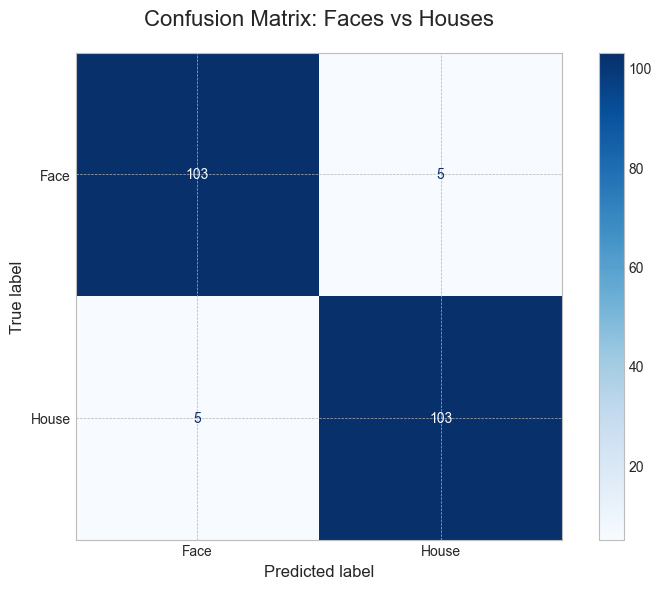

In [24]:
def binary_classification_faces_houses(processed_data):
    """Perform binary classification between faces and houses."""
    print("Performing binary classification: Faces vs Houses")

    # Extract face and house data
    conditions = processed_data['conditions']
    fmri_data = processed_data['fmri_data']

    binary_mask = np.isin(conditions, ['face', 'house'])
    X_binary = fmri_data[binary_mask]
    y_binary = conditions[binary_mask]

    print(f"Binary classification data shape: {X_binary.shape}")
    print(f"Class distribution: {np.unique(y_binary, return_counts=True)}")

    # Train SVM with cross-validation
    svm_classifier = SVC(kernel='linear', random_state=42)
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Cross-validation scores
    cv_scores = cross_val_score(svm_classifier, X_binary, y_binary, cv=cv_strategy, scoring='accuracy')

    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean accuracy: {np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")

    # Generate predictions for confusion matrix
    y_pred = cross_val_predict(svm_classifier, X_binary, y_binary, cv=cv_strategy)

    # Create confusion matrix
    cm = confusion_matrix(y_binary, y_pred, labels=['face', 'house'])

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Face', 'House'])
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title("Confusion Matrix: Faces vs Houses", fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

    return {
        'scores': cv_scores,
        'mean_accuracy': np.mean(cv_scores),
        'predictions': y_pred,
        'true_labels': y_binary,
        'confusion_matrix': cm
    }

# Perform binary classification
binary_results = binary_classification_faces_houses(processed_data)

### Spatial Searchlight Decoding (Faces vs. Houses)

**Searchlight analysis** is a method that moves a spherical window throughout the brain, training a classifier at each location using only local voxel patterns.

This analysis helps identify *where* in the brain information about stimulus categories is encoded. Visualized classification accuracy as a brain map and highlight regions like:
- **Fusiform face area (FFA)** for faces
- **Parahippocampal place area (PPA)** for houses

Only voxels with accuracy above chance (0.5) or a high threshold are considered meaningful.

Performing searchlight analysis...
Searchlight data shape: (40, 64, 64, 216)
Conditions: (array(['face', 'house'], dtype=object), array([108, 108]))
Running searchlight analysis (this may take several minutes)...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.


[_group_iter_search_light] Job #2, processed 0/47 steps (0.00%, 1426.5 seconds remaining)

[_group_iter_search_light] Job #1, processed 0/47 steps (0.00%, 2306.3 seconds remaining)

[_group_iter_search_light] Job #8, processed 0/46 steps (0.00%, 2699.7 seconds remaining)

[_group_iter_search_light] Job #3, processed 0/47 steps (0.00%, 2730.6 seconds remaining)

[_group_iter_search_light] Job #4, processed 0/47 steps (0.00%, 2406.3 seconds remaining)

[_group_iter_search_light] Job #7, processed 0/46 steps (0.00%, 3350.6 seconds remaining)

[_group_iter_search_light] Job #6, processed 0/46 steps (0.00%, 3259.8 seconds remaining)

[_group_iter_search_light] Job #5, processed 0/46 steps (0.00%, 3565.8 seconds remaining)

[_group_iter_search_light] Job #10, processed 0/46 steps (0.00%, 5377.3 seconds remaining)

[_group_iter_search_light] Job #4, processed 10/47 steps (21.28%, 5.4 seconds remaining)

[_group_iter_search_light] Job #9, processed 0/46 steps (0.00%, 21095.3 seconds remaining)

[Parallel(n_jobs=-1)]: Done   2 out of  10 | elapsed:   21.6s remaining:  1.4min


[_group_iter_search_light] Job #1, processed 40/47 steps (85.11%, 3.1 seconds remaining)

[_group_iter_search_light] Job #10, processed 20/46 steps (43.48%, 25.1 seconds remaining)

[_group_iter_search_light] Job #6, processed 30/46 steps (65.22%, 10.9 seconds remaining)

[_group_iter_search_light] Job #2, processed 40/47 steps (85.11%, 3.7 seconds remaining)

[_group_iter_search_light] Job #9, processed 20/46 steps (43.48%, 34.7 seconds remaining)

[_group_iter_search_light] Job #8, processed 20/46 steps (43.48%, 35.9 seconds remaining)

[_group_iter_search_light] Job #10, processed 30/46 steps (65.22%, 14.9 seconds remaining)

[_group_iter_search_light] Job #7, processed 20/46 steps (43.48%, 36.7 seconds remaining)

[_group_iter_search_light] Job #3, processed 30/47 steps (63.83%, 17.2 seconds remaining)

[_group_iter_search_light] Job #6, processed 40/46 steps (86.96%, 4.9 seconds remaining)

[_group_iter_search_light] Job #7, processed 30/46 steps (65.22%, 18.0 seconds remaining)



[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   54.6s finished


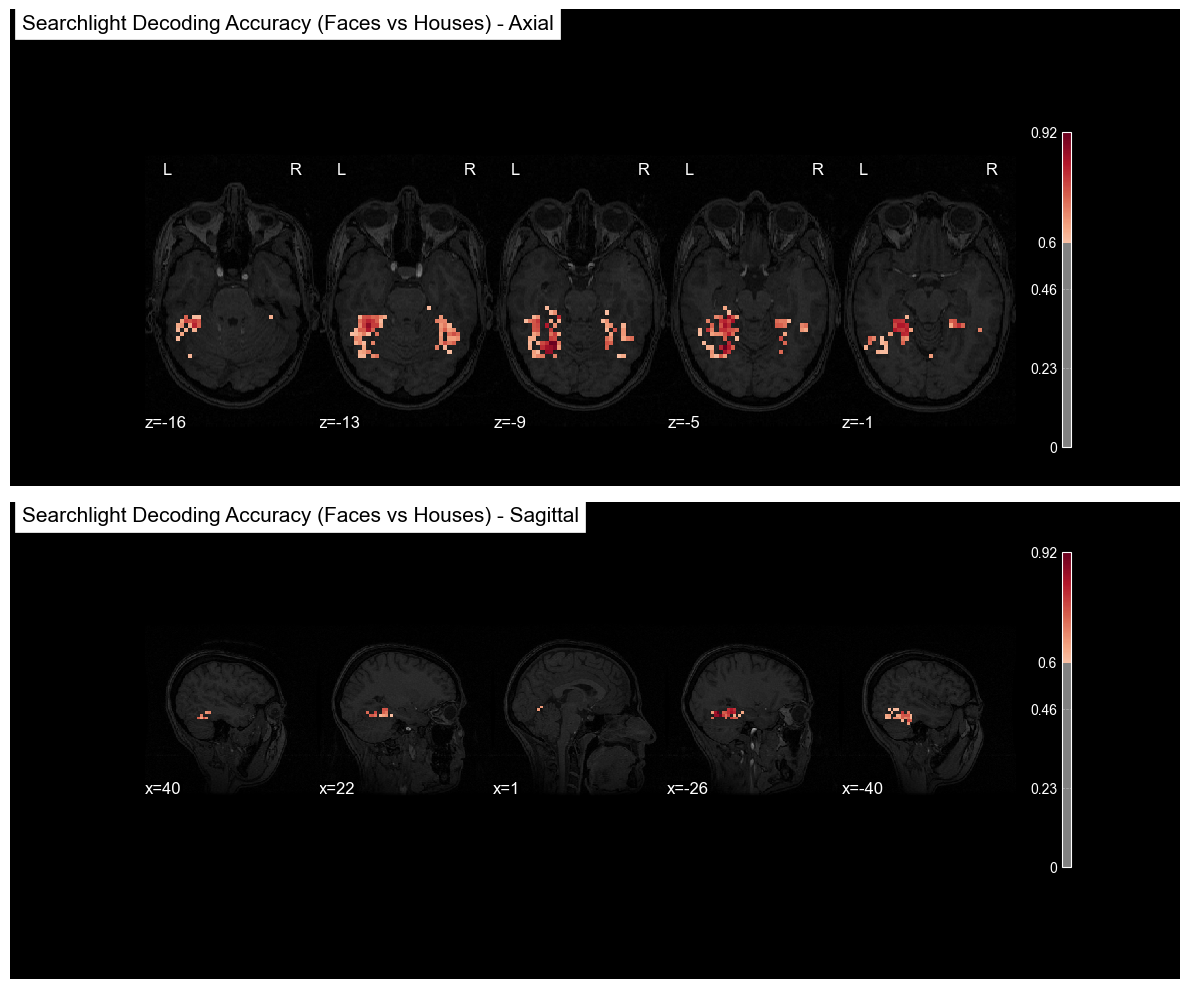

Searchlight Results Summary:
- Max accuracy: 0.921
- Mean accuracy: 0.639
- Voxels above chance (>0.5): 436
- Voxels above 0.6: 281


In [25]:
def perform_searchlight_analysis(data_dict, processed_data):
    """Perform searchlight decoding analysis."""
    print("Performing searchlight analysis...")

    # Prepare data for searchlight (need full 4D image)
    behavioral = data_dict['behavioral']
    fmri_img = data_dict['fmri_img']

    # Create binary mask for face vs house
    binary_condition_mask = np.isin(behavioral['labels'].values, ['face', 'house'])

    # Extract relevant time points
    fmri_subset = index_img(fmri_img, np.where(binary_condition_mask)[0])
    conditions_subset = behavioral['labels'].values[binary_condition_mask]

    print(f"Searchlight data shape: {fmri_subset.shape}")
    print(f"Conditions: {np.unique(conditions_subset, return_counts=True)}")

    # Configure searchlight
    searchlight = SearchLight(
        mask_img=data_dict['masks']['ventral_temporal'],
        process_mask_img=data_dict['masks']['ventral_temporal'],
        radius=5.6,  # mm
        estimator=SVC(kernel="linear", random_state=42),
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    # Fit searchlight
    print("Running searchlight analysis (this may take several minutes)...")
    searchlight.fit(fmri_subset, conditions_subset)

    # Create searchlight results image
    searchlight_img = image.new_img_like(data_dict['masks']['ventral_temporal'], searchlight.scores_)

    # Visualize results
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # Axial view
    plotting.plot_stat_map(
        searchlight_img,
        bg_img=data_dict['dataset'].anat[0],
        title="Searchlight Decoding Accuracy (Faces vs Houses) - Axial",
        threshold=0.6,
        display_mode='z',
        cut_coords=5,
        axes=axes[0],
        colorbar=True
    )

    # Sagittal view
    plotting.plot_stat_map(
        searchlight_img,
        bg_img=data_dict['dataset'].anat[0],
        title="Searchlight Decoding Accuracy (Faces vs Houses) - Sagittal",
        threshold=0.6,
        display_mode='x',
        cut_coords=5,
        axes=axes[1],
        colorbar=True
    )

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    accuracy_values = searchlight.scores_[searchlight.scores_ > 0]
    print(f"Searchlight Results Summary:")
    print(f"- Max accuracy: {np.max(accuracy_values):.3f}")
    print(f"- Mean accuracy: {np.mean(accuracy_values):.3f}")
    print(f"- Voxels above chance (>0.5): {np.sum(accuracy_values > 0.5)}")
    print(f"- Voxels above 0.6: {np.sum(accuracy_values > 0.6)}")

    return {
        'searchlight_img': searchlight_img,
        'scores': searchlight.scores_,
        'max_accuracy': np.max(accuracy_values),
        'mean_accuracy': np.mean(accuracy_values)
    }

# Perform searchlight analysis
searchlight_results = perform_searchlight_analysis(data_dict, processed_data)

### Representational Similarity Analysis (RSA)

**RSA** compares the structure of neural activation patterns with the structure of stimulus categories.

-  Computed a **neural dissimilarity matrix**: pairwise distances (correlation) between all trials' activation patterns.
- Built a **category dissimilarity matrix**: 0 if two trials belong to the same class (e.g., both "face"), 1 if they differ.

By correlating these two matrices, we can test whether the similarity of neural activity patterns reflects stimulus categories. This supports the idea that the brain represents categorical information in its activation geometry.

Performing Representational Similarity Analysis (RSA)...
RSA data shape: (216, 464)


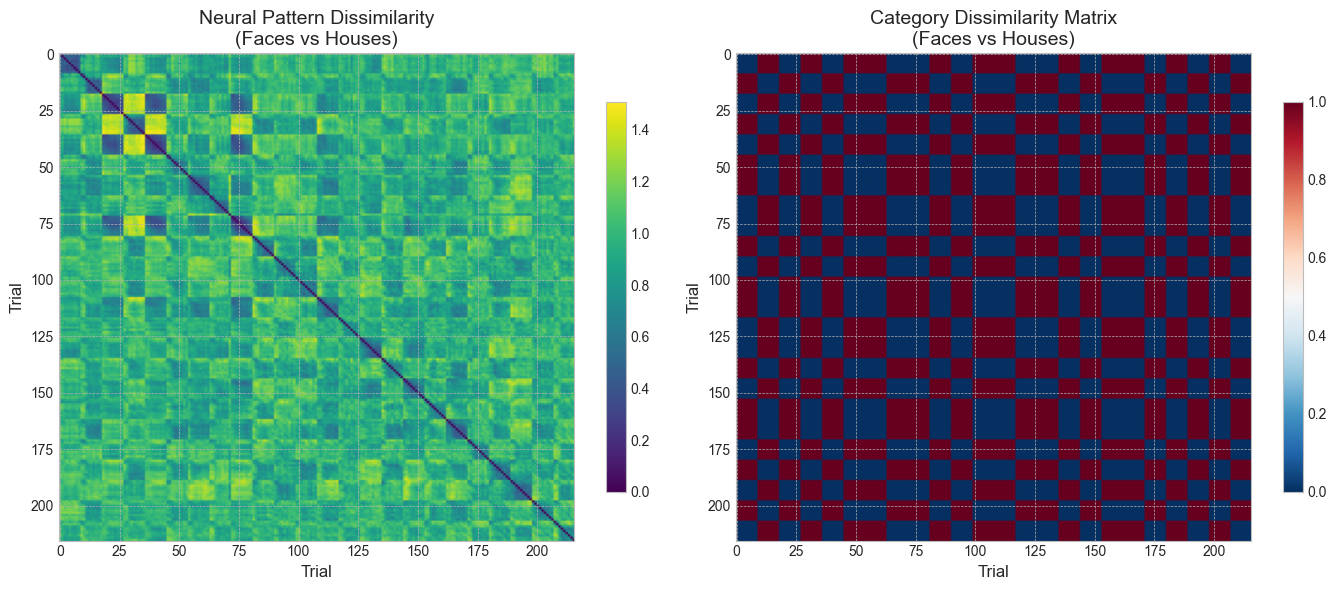

RSA Results:
- Correlation between neural and category dissimilarity: 0.340
- Mean within-category dissimilarity: 0.900
- Mean between-category dissimilarity: 1.014


In [26]:
def perform_rsa_analysis(processed_data):
    """Perform Representational Similarity Analysis."""
    print("Performing Representational Similarity Analysis (RSA)...")

    # Extract face and house data
    conditions = processed_data['conditions']
    fmri_data = processed_data['fmri_data']

    binary_mask = np.isin(conditions, ['face', 'house'])
    X_rsa = fmri_data[binary_mask]
    y_rsa = conditions[binary_mask]

    print(f"RSA data shape: {X_rsa.shape}")

    # Compute neural dissimilarity matrix (using correlation distance)
    neural_dissimilarity = squareform(pdist(X_rsa, metric='correlation'))

    # Create category dissimilarity matrix
    label_binary = np.array([0 if label == 'face' else 1 for label in y_rsa])
    category_dissimilarity = (label_binary[:, None] != label_binary[None, :]).astype(float)

    # Visualize both matrices
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Neural dissimilarity
    im1 = ax1.imshow(neural_dissimilarity, cmap='viridis', aspect='auto')
    ax1.set_title("Neural Pattern Dissimilarity\n(Faces vs Houses)", fontsize=14)
    ax1.set_xlabel("Trial")
    ax1.set_ylabel("Trial")
    plt.colorbar(im1, ax=ax1, shrink=0.8)

    # Category dissimilarity
    im2 = ax2.imshow(category_dissimilarity, cmap='RdBu_r', aspect='auto')
    ax2.set_title("Category Dissimilarity Matrix\n(Faces vs Houses)", fontsize=14)
    ax2.set_xlabel("Trial")
    ax2.set_ylabel("Trial")
    plt.colorbar(im2, ax=ax2, shrink=0.8)

    plt.tight_layout()
    plt.show()

    # Compute correlation between neural and category dissimilarity
    # Flatten upper triangle to avoid diagonal and redundant comparisons
    mask = np.triu(np.ones_like(neural_dissimilarity, dtype=bool), k=1)
    neural_flat = neural_dissimilarity[mask]
    category_flat = category_dissimilarity[mask]

    correlation = np.corrcoef(neural_flat, category_flat)[0, 1]

    print(f"RSA Results:")
    print(f"- Correlation between neural and category dissimilarity: {correlation:.3f}")
    print(f"- Mean within-category dissimilarity: {np.mean(neural_flat[category_flat == 0]):.3f}")
    print(f"- Mean between-category dissimilarity: {np.mean(neural_flat[category_flat == 1]):.3f}")

    return {
        'neural_dissimilarity': neural_dissimilarity,
        'category_dissimilarity': category_dissimilarity,
        'correlation': correlation
    }

# Perform RSA analysis
rsa_results = perform_rsa_analysis(processed_data)

### Multi-class Classification: All Stimulus Categories

Extended the binary classifier to a **multi-class** setting using **logistic regression** with one-vs-rest (OvR) strategy.

- Feature selection (ANOVA F-score) is used to reduce dimensionality.
- A **grid search** tunes hyperparameters using cross-validation.
- A **leave-one-run-out** cross-validation scheme.
- Results are visualized via a **confusion matrix** and **ROC curves** for each class.

This helps reveal how well the brain differentiates among all visual categories.

Performing multi-class classification with feature selection...
Multi-class data shape: (864, 464)
Classes: ['bottle' 'cat' 'chair' 'face' 'house' 'scissors' 'scrambledpix' 'shoe']
Class distribution: {'bottle': np.int64(108), 'cat': np.int64(108), 'chair': np.int64(108), 'face': np.int64(108), 'house': np.int64(108), 'scissors': np.int64(108), 'scrambledpix': np.int64(108), 'shoe': np.int64(108)}
Starting 12-fold cross-validation...
Processing fold 1...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

  Fold 1 accuracy: 0.722
  Best params: {'classifier__C': 0.01, 'feature_selection__k': 500}
Processing fold 2...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

  Fold 2 accuracy: 0.667
  Best params: {'classifier__C': 0.01, 'feature_selection__k': 500}
Processing fold 3...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

  Fold 3 accuracy: 0.583
  Best params: {'classifier__C': 0.01, 'feature_selection__k': 500}
Processing fold 4...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

  Fold 4 accuracy: 0.611
  Best params: {'classifier__C': 0.01, 'feature_selection__k': 500}
Processing fold 5...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

  Fold 5 accuracy: 0.750
  Best params: {'classifier__C': 0.01, 'feature_selection__k': 500}
Processing fold 6...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

  Fold 6 accuracy: 0.750
  Best params: {'classifier__C': 0.01, 'feature_selection__k': 500}
Processing fold 7...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

  Fold 7 accuracy: 0.542
  Best params: {'classifier__C': 0.01, 'feature_selection__k': 500}
Processing fold 8...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

  Fold 8 accuracy: 0.583
  Best params: {'classifier__C': 0.01, 'feature_selection__k': 500}
Processing fold 9...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

  Fold 9 accuracy: 0.833
  Best params: {'classifier__C': 0.01, 'feature_selection__k': 500}
Processing fold 10...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

  Fold 10 accuracy: 0.639
  Best params: {'classifier__C': 0.1, 'feature_selection__k': 500}
Processing fold 11...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

  Fold 11 accuracy: 0.597
  Best params: {'classifier__C': 0.01, 'feature_selection__k': 500}
Processing fold 12...


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

  Fold 12 accuracy: 0.694
  Best params: {'classifier__C': 0.01, 'feature_selection__k': 500}

Multi-class Classification Results:
- Mean accuracy: 0.664 ± 0.083
- Individual fold accuracies: ['0.722', '0.667', '0.583', '0.611', '0.750', '0.750', '0.542', '0.583', '0.833', '0.639', '0.597', '0.694']


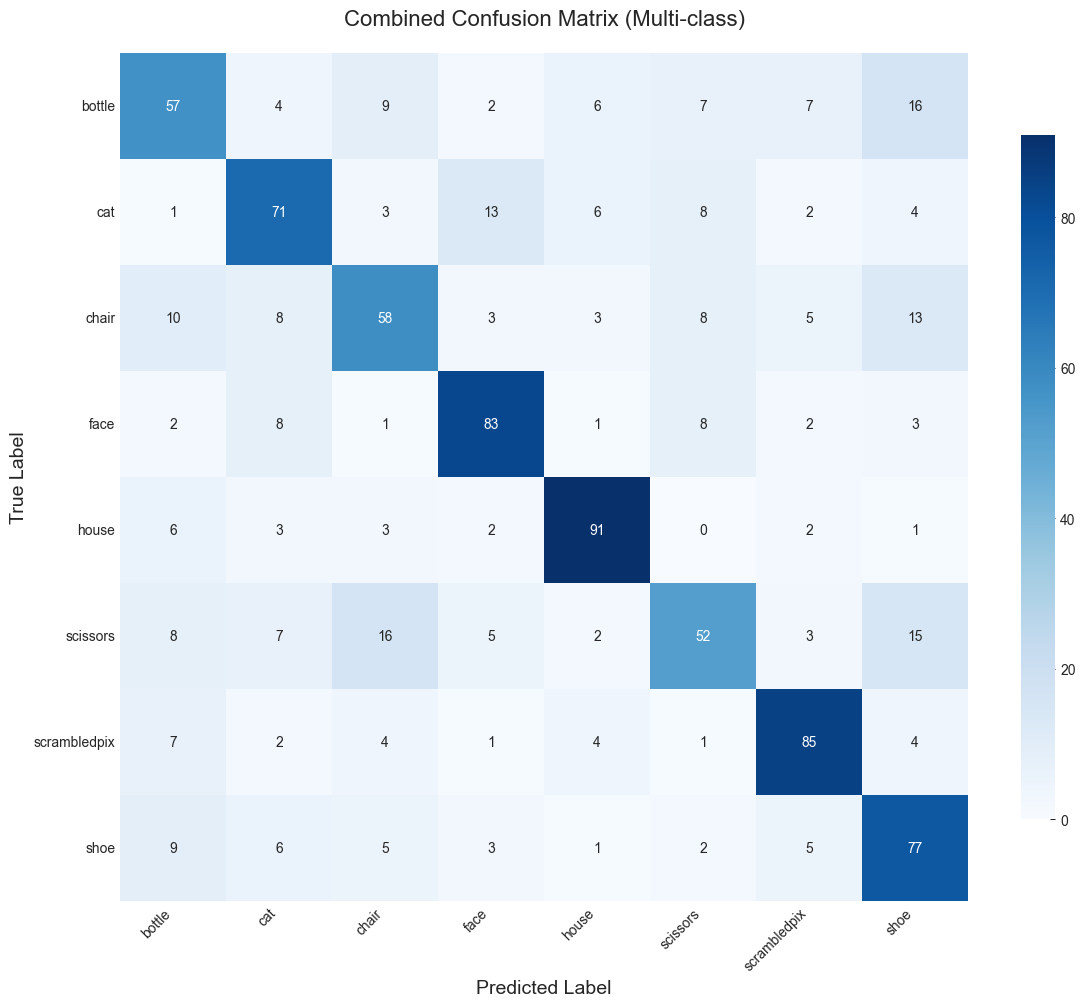

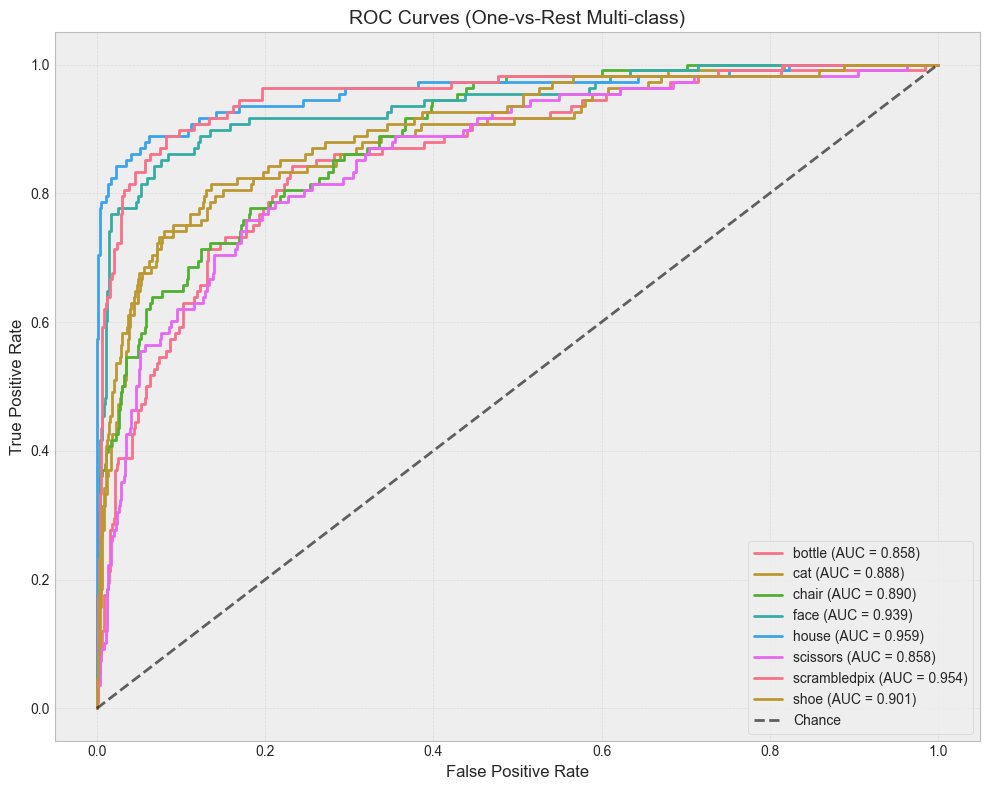


AUC Scores by Class:
- bottle: 0.858
- cat: 0.888
- chair: 0.890
- face: 0.939
- house: 0.959
- scissors: 0.858
- scrambledpix: 0.954
- shoe: 0.901


In [27]:
def multiclass_classification_with_feature_selection(processed_data):
    """Perform multi-class classification with feature selection and hyperparameter tuning."""
    print("Performing multi-class classification with feature selection...")

    X = processed_data['fmri_data']
    y = processed_data['conditions']
    groups = processed_data['runs']

    print(f"Multi-class data shape: {X.shape}")
    print(f"Classes: {np.unique(y)}")
    print(f"Class distribution: {dict(zip(*np.unique(y, return_counts=True)))}")

    # Setup models and cross-validation
    base_model = LogisticRegression(
        penalty='l2',
        multi_class='ovr',
        solver='liblinear',
        max_iter=1000,
        random_state=42
    )

    # Create pipeline with feature selection
    pipeline = Pipeline([
        ('feature_selection', SelectKBest(f_classif, k=200)),
        ('classifier', base_model)
    ])

    # Hyperparameter grid
    param_grid = {
        'classifier__C': [0.01, 0.1, 1, 10, 100],
        'feature_selection__k': [100, 200, 500, 1000]
    }

    # Leave-one-run-out cross-validation
    logo_cv = LeaveOneGroupOut()

    # Storage for results
    fold_accuracies = []
    all_y_true = []
    all_y_pred = []
    all_y_pred_proba = []
    confusion_matrices = []

    unique_classes = np.unique(y)
    n_classes = len(unique_classes)

    print(f"Starting {logo_cv.get_n_splits(X, y, groups)}-fold cross-validation...")

    for fold, (train_idx, test_idx) in enumerate(logo_cv.split(X, y, groups), 1):
        print(f"Processing fold {fold}...")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Grid search with inner CV
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        grid_search = GridSearchCV(
            pipeline,
            param_grid,
            cv=inner_cv,
            scoring='accuracy',
            n_jobs=-1
        )

        # Fit and predict
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_

        # Test set predictions
        y_pred = best_model.predict(X_test)
        y_pred_proba = best_model.predict_proba(X_test)

        # Store results
        fold_accuracy = best_model.score(X_test, y_test)
        fold_accuracies.append(fold_accuracy)

        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
        all_y_pred_proba.extend(y_pred_proba)

        # Confusion matrix for this fold
        cm_fold = confusion_matrix(y_test, y_pred, labels=unique_classes)
        confusion_matrices.append(cm_fold)

        print(f"  Fold {fold} accuracy: {fold_accuracy:.3f}")
        print(f"  Best params: {grid_search.best_params_}")

    # Aggregate results
    mean_accuracy = np.mean(fold_accuracies)
    std_accuracy = np.std(fold_accuracies)

    print(f"\nMulti-class Classification Results:")
    print(f"- Mean accuracy: {mean_accuracy:.3f} ± {std_accuracy:.3f}")
    print(f"- Individual fold accuracies: {[f'{acc:.3f}' for acc in fold_accuracies]}")

    # Combined confusion matrix
    combined_cm = np.sum(confusion_matrices, axis=0)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        combined_cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=unique_classes,
        yticklabels=unique_classes,
        square=True,
        cbar_kws={"shrink": 0.8}
    )
    plt.title("Combined Confusion Matrix (Multi-class)", fontsize=16, pad=20)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # ROC curves for each class
    y_true_array = np.array(all_y_true)
    y_pred_proba_array = np.array(all_y_pred_proba)

    plt.figure(figsize=(10, 8))
    auc_scores = []

    for i, class_name in enumerate(unique_classes):
        # One-vs-rest binary classification
        y_true_binary = (y_true_array == class_name).astype(int)
        y_scores = y_pred_proba_array[:, i]

        fpr, tpr, _ = roc_curve(y_true_binary, y_scores)
        auc = roc_auc_score(y_true_binary, y_scores)
        auc_scores.append(auc)

        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {auc:.3f})', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', alpha=0.6, label='Chance')
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves (One-vs-Rest Multi-class)', fontsize=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Print AUC scores
    print(f"\nAUC Scores by Class:")
    for class_name, auc in zip(unique_classes, auc_scores):
        print(f"- {class_name}: {auc:.3f}")

    return {
        'fold_accuracies': fold_accuracies,
        'mean_accuracy': mean_accuracy,
        'std_accuracy': std_accuracy,
        'confusion_matrix': combined_cm,
        'auc_scores': auc_scores,
        'class_names': unique_classes
    }

# Perform multi-class classification
multiclass_results = multiclass_classification_with_feature_selection(processed_data)

### Classification After Removing Top Voxels

Repeated the multi-class classification, but **remove the top N most informative voxels** (based on ANOVA scores) before training.

This tests how dependent decoding performance is on a few highly informative voxels. A drop in accuracy indicates strong reliance on specific voxels, while stable performance suggests distributed coding across the brain.

Performing classification with top 100 voxels removed...
Starting cross-validation with voxel removal...
Processing fold 1...
  Reduced from 464 to 364 voxels


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

  Fold 1 accuracy (removed 100 voxels): 0.667
  Best params: {'C': 0.1}
Processing fold 2...
  Reduced from 464 to 364 voxels


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

  Fold 2 accuracy (removed 100 voxels): 0.667
  Best params: {'C': 0.01}
Processing fold 3...
  Reduced from 464 to 364 voxels


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

  Fold 3 accuracy (removed 100 voxels): 0.556
  Best params: {'C': 0.01}
Processing fold 4...
  Reduced from 464 to 364 voxels


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

  Fold 4 accuracy (removed 100 voxels): 0.556
  Best params: {'C': 0.01}
Processing fold 5...
  Reduced from 464 to 364 voxels


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

  Fold 5 accuracy (removed 100 voxels): 0.653
  Best params: {'C': 0.01}
Processing fold 6...
  Reduced from 464 to 364 voxels


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

  Fold 6 accuracy (removed 100 voxels): 0.694
  Best params: {'C': 0.01}
Processing fold 7...
  Reduced from 464 to 364 voxels


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

  Fold 7 accuracy (removed 100 voxels): 0.500
  Best params: {'C': 0.1}
Processing fold 8...
  Reduced from 464 to 364 voxels


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

  Fold 8 accuracy (removed 100 voxels): 0.500
  Best params: {'C': 0.01}
Processing fold 9...
  Reduced from 464 to 364 voxels


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

  Fold 9 accuracy (removed 100 voxels): 0.736
  Best params: {'C': 0.01}
Processing fold 10...
  Reduced from 464 to 364 voxels


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

  Fold 10 accuracy (removed 100 voxels): 0.583
  Best params: {'C': 0.01}
Processing fold 11...
  Reduced from 464 to 364 voxels


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

  Fold 11 accuracy (removed 100 voxels): 0.500
  Best params: {'C': 0.01}
Processing fold 12...
  Reduced from 464 to 364 voxels


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn

  Fold 12 accuracy (removed 100 voxels): 0.694
  Best params: {'C': 0.01}

Classification with Top Voxels Removed Results (N=100):
- Mean accuracy: 0.609 ± 0.082
- Individual fold accuracies: ['0.667', '0.667', '0.556', '0.556', '0.653', '0.694', '0.500', '0.500', '0.736', '0.583', '0.500', '0.694']


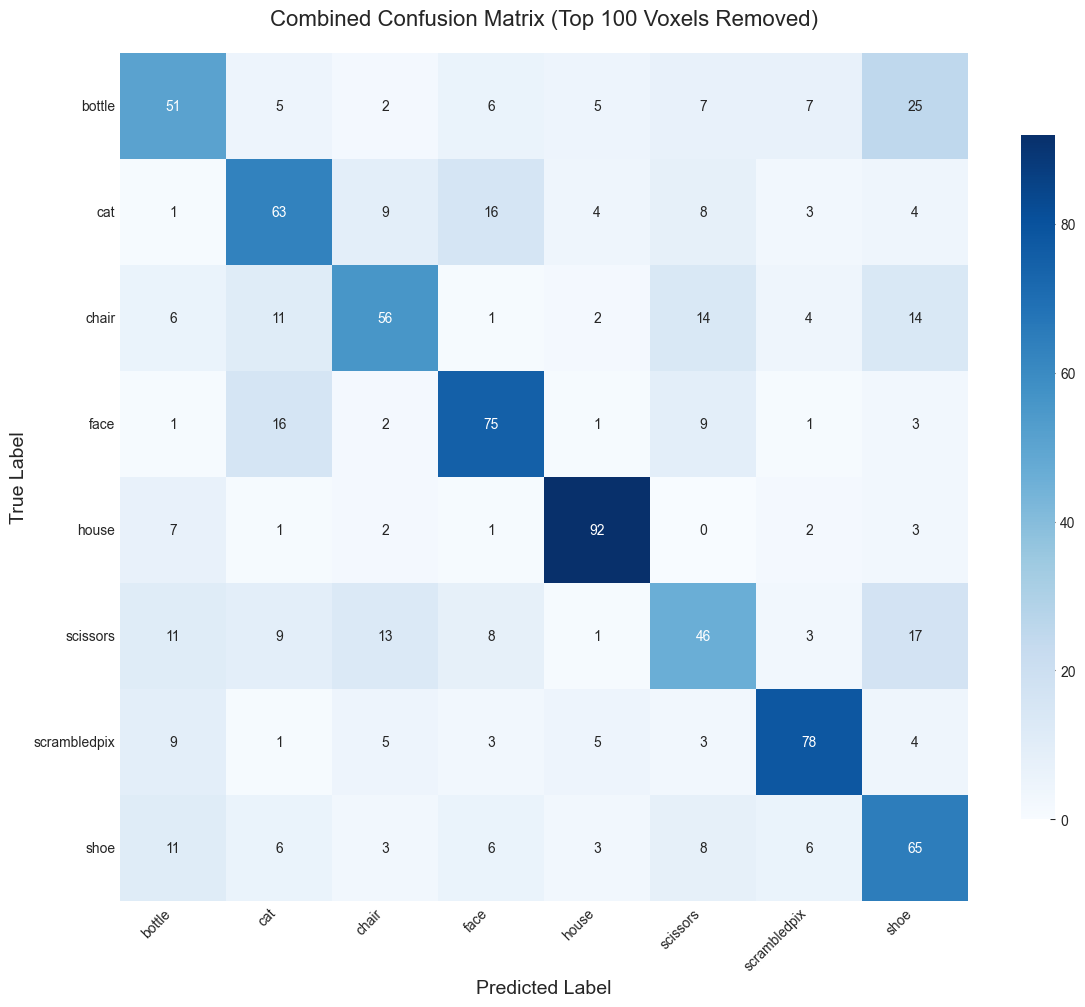

In [28]:
def classification_with_top_voxels_removed(processed_data, n_voxels_to_remove=100):
    """Perform classification after removing the most informative voxels."""
    print(f"Performing classification with top {n_voxels_to_remove} voxels removed...")

    X = processed_data['fmri_data']
    y = processed_data['conditions']
    groups = processed_data['runs']

    # Setup
    base_model = LogisticRegression(
        penalty='l2',
        multi_class='ovr',
        solver='liblinear',
        max_iter=1000,
        random_state=42
    )

    param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
    logo_cv = LeaveOneGroupOut()

    fold_accuracies = []
    all_y_true = []
    all_y_pred = []
    confusion_matrices = []
    unique_classes = np.unique(y)

    print(f"Starting cross-validation with voxel removal...")

    for fold, (train_idx, test_idx) in enumerate(logo_cv.split(X, y, groups), 1):
        print(f"Processing fold {fold}...")

        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Identify top voxels to remove
        selector = SelectKBest(f_classif, k=n_voxels_to_remove)
        selector.fit(X_train, y_train)
        top_voxel_indices = selector.get_support(indices=True)

        # Remove top voxels
        remaining_voxel_indices = np.setdiff1d(np.arange(X_train.shape[1]), top_voxel_indices)
        X_train_reduced = X_train[:, remaining_voxel_indices]
        X_test_reduced = X_test[:, remaining_voxel_indices]

        print(f"  Reduced from {X_train.shape[1]} to {X_train_reduced.shape[1]} voxels")

        # Grid search with cross-validation on training set
        grid_search = GridSearchCV(
            base_model,
            param_grid,
            cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
            scoring='accuracy',
            n_jobs=-1
        )

        # Fit and predict
        grid_search.fit(X_train_reduced, y_train)
        best_model = grid_search.best_estimator_

        y_pred = best_model.predict(X_test_reduced)

        # Store results
        fold_accuracy = best_model.score(X_test_reduced, y_test)
        fold_accuracies.append(fold_accuracy)

        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)

        cm_fold = confusion_matrix(y_test, y_pred, labels=unique_classes)
        confusion_matrices.append(cm_fold)

        print(f"  Fold {fold} accuracy (removed {n_voxels_to_remove} voxels): {fold_accuracy:.3f}")
        print(f"  Best params: {grid_search.best_params_}")

    # Aggregate results
    mean_accuracy = np.mean(fold_accuracies)
    std_accuracy = np.std(fold_accuracies)

    print(f"\nClassification with Top Voxels Removed Results (N={n_voxels_to_remove}):")
    print(f"- Mean accuracy: {mean_accuracy:.3f} ± {std_accuracy:.3f}")
    print(f"- Individual fold accuracies: {[f'{acc:.3f}' for acc in fold_accuracies]}")

    # Combined confusion matrix
    combined_cm = np.sum(confusion_matrices, axis=0)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        combined_cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=unique_classes,
        yticklabels=unique_classes,
        square=True,
        cbar_kws={"shrink": 0.8}
    )
    plt.title(f"Combined Confusion Matrix (Top {n_voxels_to_remove} Voxels Removed)", fontsize=16, pad=20)
    plt.xlabel("Predicted Label", fontsize=14)
    plt.ylabel("True Label", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return {
        'fold_accuracies': fold_accuracies,
        'mean_accuracy': mean_accuracy,
        'std_accuracy': std_accuracy,
        'confusion_matrix': combined_cm,
        'n_voxels_removed': n_voxels_to_remove
    }

# Perform classification with top voxels removed
removed_voxels_results = classification_with_top_voxels_removed(processed_data, n_voxels_to_remove=100)

The decoding pipeline applied to the Haxby 2001 dataset yielded highly accurate classification of visual categories (face vs. house) based on fMRI signals. The cross-validation scores across 5 folds were exceptionally high: [0.9545, 0.9767, 0.9767, 0.9302, 0.9302] with a mean accuracy of 0.954 ± 0.021, indicating robust and generalizable performance of the linear SVM classifier for this binary task.

The confusion matrix for the binary classification (Faces vs Houses) visually confirms this strong performance. The model correctly identified 103 out of 108 face trials and 103 out of 108 house trials. Only 5 face samples were misclassified as house, and 5 house samples were misclassified as face. This high accuracy reflects highly discriminable neural patterns between face and house stimuli in the ventral temporal cortex.

The searchlight decoding analysis further reveals where this information is spatially localized in the brain. Clusters of high classification accuracy (above 0.6) are prominently observed bilaterally in the fusiform gyrus and parahippocampal cortex, which are known to selectively respond to faces and scenes, respectively. The peak accuracy observed in these regions approaches 0.921, suggesting concentrated regions of category-specific neural coding. These results mirror known functional specializations (FFA and PPA) and validate the effectiveness of localized MVPA approaches. The mean accuracy across all voxels with scores above zero was 0.639.

In the Representational Similarity Analysis (RSA), the neural dissimilarity matrix shows distinct block patterns, where within-category comparisons (face-face or house-house) show lower dissimilarity (e.g., green/yellow colors), and between-category comparisons show higher dissimilarity (e.g., purple colors). The category dissimilarity matrix, encoding binary differences between face and house labels, forms a clear checkerboard pattern. The alignment of structure between the neural and category matrices indicates that the brain's activation patterns reflect category membership. This is quantitatively supported by a correlation of 0.340 between the neural and category dissimilarity matrices. The mean within-category dissimilarity was 0.900 and the mean between-category dissimilarity was 1.014, showing that neural patterns within the same category are indeed more similar than those between different categories.

For the multi-class classification involving all stimulus categories, the Logistic Regression model with feature selection achieved a mean accuracy of 0.664 ± 0.083 across the 12 Leave-One-Group-Out cross-validation folds. The combined confusion matrix illustrates the model's ability to classify across all 8 categories, with varying degrees of success for each. Categories like 'face' and 'house' show high correct classification rates (83 and 91 respectively), while others like 'scissors' (52 correct) or 'bottle' (57 correct) show more confusion with other categories. The ROC curves and associated AUC scores further detail the discriminability for each class in a one-vs-rest manner. 'House' (AUC = 0.959) and 'scrambledpix' (AUC = 0.954) had the highest AUCs, followed by 'face' (AUC = 0.939), indicating strong discriminative power for these categories.

Finally, an exploratory analysis was conducted where the top 100 most informative voxels were removed prior to multi-class classification. This resulted in a mean accuracy of 0.609 ± 0.082. While this represents a slight drop in performance compared to the full multi-class classification (0.664), the accuracy remains well above chance. The confusion matrix for this scenario shows a general decrease in correct classifications across categories, with increased off-diagonal entries. This suggests that while the top voxels contribute significantly to classification, the information for discriminating between categories is distributed across a wider set of voxels, allowing for substantial decoding even after the removal of the most salient features. This highlights the distributed nature of neural representations for visual categories.